Loading the Dependencies

In [188]:
import tensorflow as tf # to load the data and to make a data pipeline (later also to build the model)
import os # to navigate through files and interact with the system
import numpy as np #to read images as Numpy array and to do mathematical operations on them 
import matplotlib.pyplot as plt #to plot the graphs and images 
import cv2 #to read the image

In [193]:
train_data = "D:\Intern\Data Science\Intern_Project\Train"  #put the path of the training data here 

In [194]:
os.listdir(train_data)

['conditioning excercise', 'Sports']

Removing Dodgy images (takes about 15mins) 

In [207]:
for image_class in os.listdir(train_data):
    for image in os.listdir(os.path.join(train_data, image_class)):
        image_path = os.path.join(train_data,image_class,image)
        img = cv2.imread(image_path)
        #Check if the image is None (i.e., could not be read)
        if img is None:   
            os.remove(image_path)
        # Check if the image has low resolution
        elif img.shape[0]<75 or img.shape[1]<75:  
            os.remove(image_path)
        # Check if the image is too bright or too dark
        elif img.mean()>230 or img.mean()<20:
            os.remove(image_path)
        # Check if the image is blurry
        elif cv2.Laplacian(img, cv2.CV_64F).var() < 75:
            os.remove(image_path)

Loading the Training data

In [208]:
TRAINING_DATA = tf.keras.utils.image_dataset_from_directory(train_data)

Found 2844 files belonging to 2 classes.


In [209]:
data_iterator = TRAINING_DATA.as_numpy_iterator()  #Changing the images as numpy arrays

In [210]:
batch = data_iterator.next()  #Doing it with all the batches  

In [211]:
batch[0].shape  #(size of batch, hight in pixels, width in pixels, no of colour channels)

(32, 256, 256, 3)

In [212]:
batch[1] # randomized labels 

array([1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1])

Preprocessing Data

Scaling Data

In [213]:
TRAINING_DATA = TRAINING_DATA.map(lambda x,y:(x/255,y)) #dividing the hight and width by 255, such that it lies [0,1]

In [214]:
scaled_iterator = TRAINING_DATA.as_numpy_iterator() #Changing the scaled images as numpy arrays

In [215]:
batch = scaled_iterator.next()  #Doing it with all the batches 

In [216]:
batch[0].max()  

1.0

In [217]:
batch[0].min()

0.0

Plotting few images and checking if the images are loaded properly  

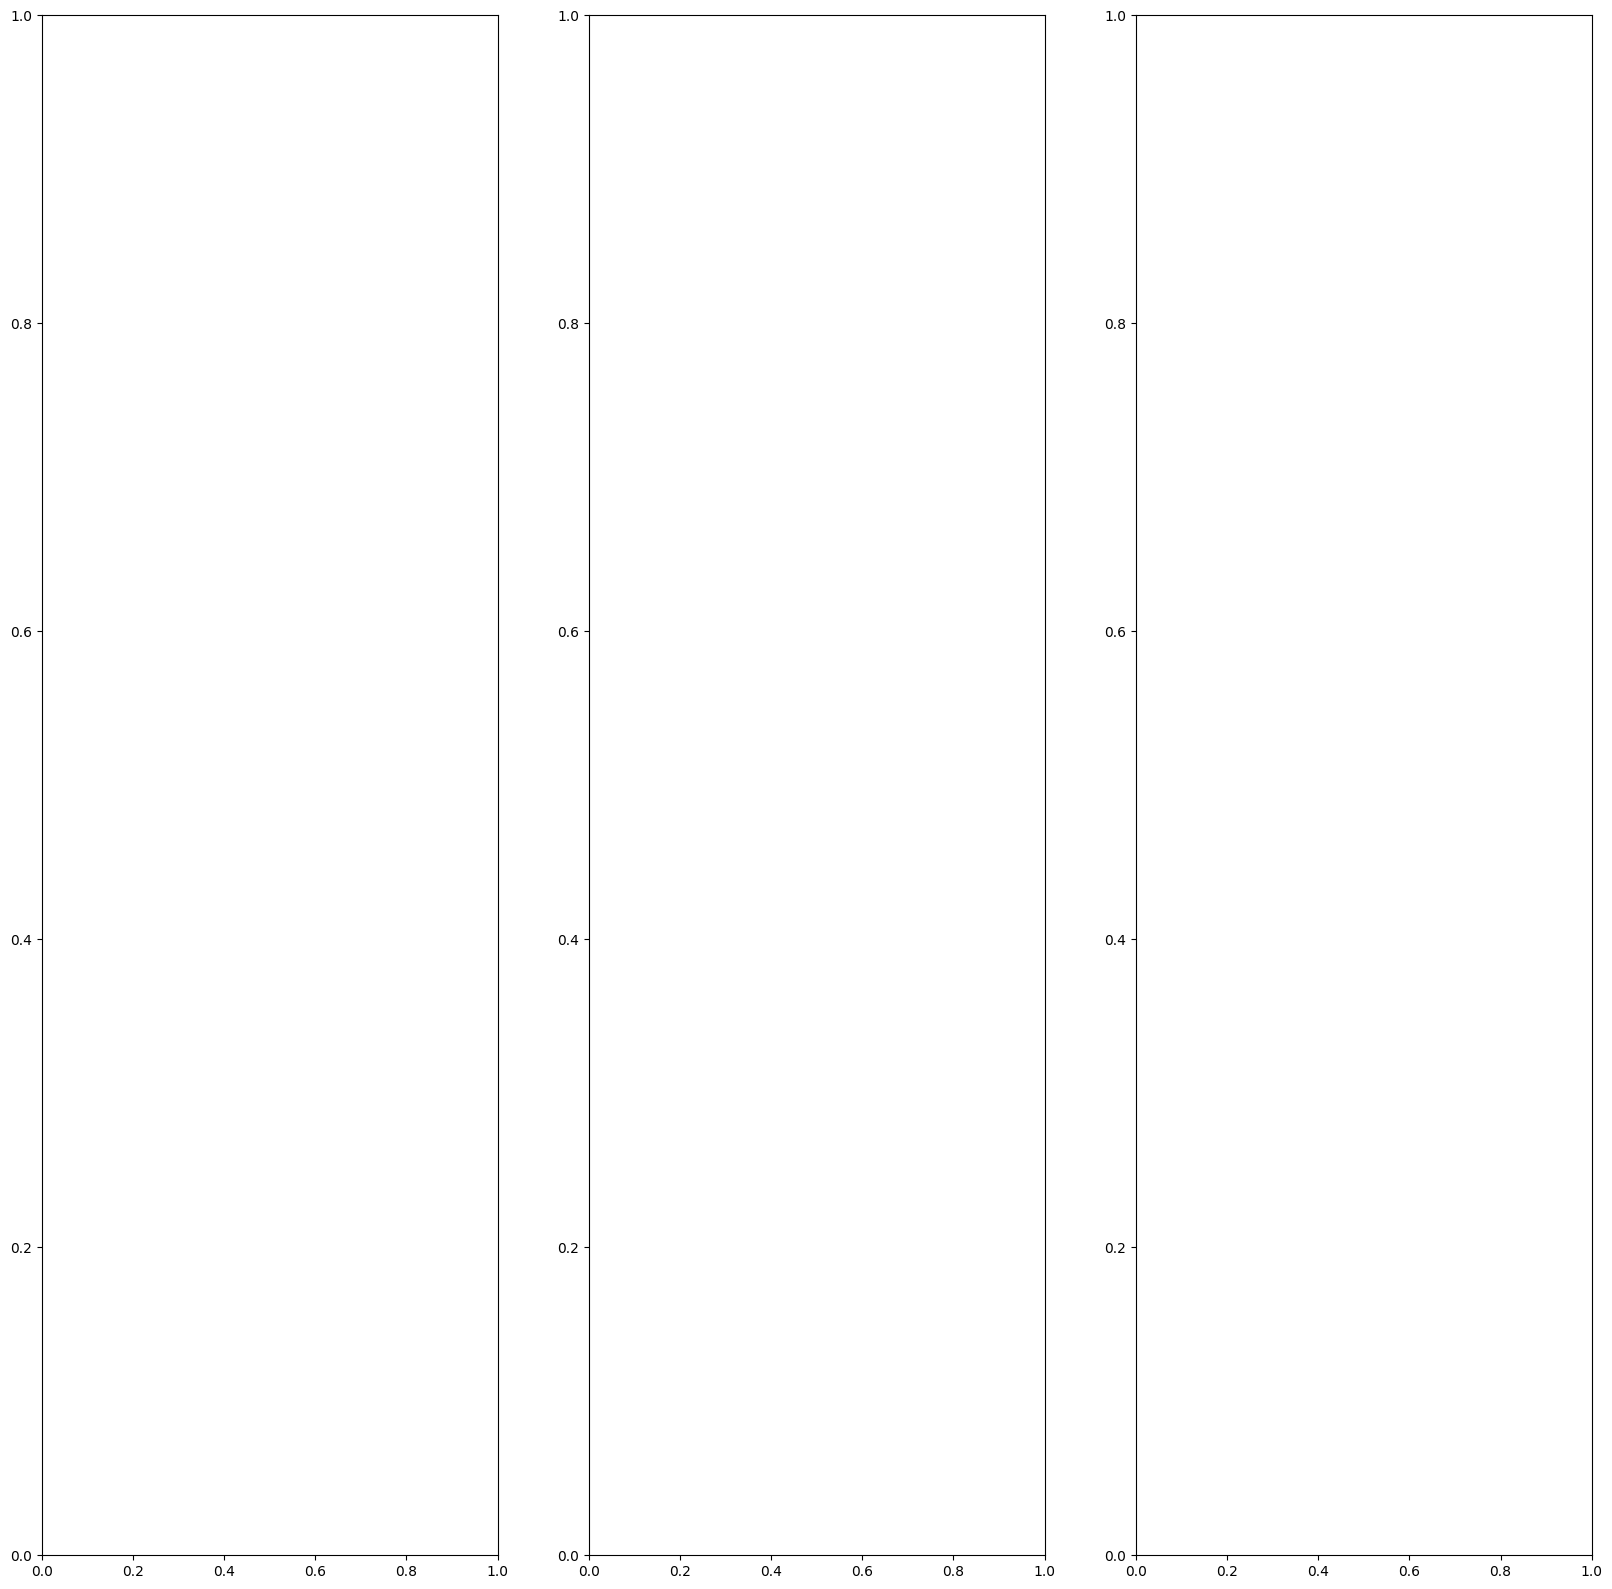

In [252]:
fig, ax = plt.subplots (ncols=3, figsize=(20,20))

for idx, img in enumerate (batch[0][10:13]): 
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Spliting the data into training and Validation data 

In [221]:
len(TRAINING_DATA) #training data contains 77 32 sized batches 

89

In [222]:
train_size = int(len(TRAINING_DATA)*0.8) #taking 80% as training 
val_size = int(len(TRAINING_DATA)*0.2) + 1  #taking 20% as validation 
print(train_size)
print(val_size)

71
18


In [223]:
train = TRAINING_DATA.take(train_size)
val = TRAINING_DATA.skip(train_size).take(val_size)

In [224]:
len(train)

71

In [225]:
len(val)

18

Making the Deep Learning Model

In [226]:
from tensorflow.keras.models import Sequential  #we will use a sequential model

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout #loading different layers for the model

from tensorflow.keras import regularizers #loading regularizers to overcome overfitting

In [227]:
model = Sequential()  #detailed explaination of the model is given in the documentation 

In [228]:
model.add(Conv2D(16, (3,3),1,activation = 'relu',input_shape=(256,256,3), kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D())

model.add(Dropout(0.20))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(Dropout(0.20))

model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

In [229]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics= ['accuracy'])

In [230]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 30, 32)      

In [231]:
logdir = "D:\Intern\Data Science\Intern_Project\logs"  #creating the log directory

In [232]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Training the Data

In [233]:
hist = model.fit(train, epochs = 20, validation_data = val, callbacks = [tensorboard_callback]) #training the model for 20 epochs

Epoch 1/20
71/71 [==============================] - 145s 2s/step - loss: 1.8849 - accuracy: 0.6576 - val_loss: 1.0322 - val_accuracy: 0.6748
Epoch 2/20
71/71 [==============================] - 140s 2s/step - loss: 0.9253 - accuracy: 0.6897 - val_loss: 0.8413 - val_accuracy: 0.7150
Epoch 3/20
71/71 [==============================] - 139s 2s/step - loss: 0.8067 - accuracy: 0.7210 - val_loss: 0.8232 - val_accuracy: 0.6731
Epoch 4/20
71/71 [==============================] - 141s 2s/step - loss: 0.7760 - accuracy: 0.7227 - val_loss: 0.7752 - val_accuracy: 0.7238
Epoch 5/20
71/71 [==============================] - 139s 2s/step - loss: 0.7485 - accuracy: 0.7403 - val_loss: 0.7905 - val_accuracy: 0.7360
Epoch 6/20
71/71 [==============================] - 143s 2s/step - loss: 0.7148 - accuracy: 0.7522 - val_loss: 0.7119 - val_accuracy: 0.7692
Epoch 7/20
71/71 [==============================] - 137s 2s/step - loss: 0.7253 - accuracy: 0.7377 - val_loss: 0.7423 - val_accuracy: 0.7045
Epoch 8/20
71

Plotting the Losses Graph

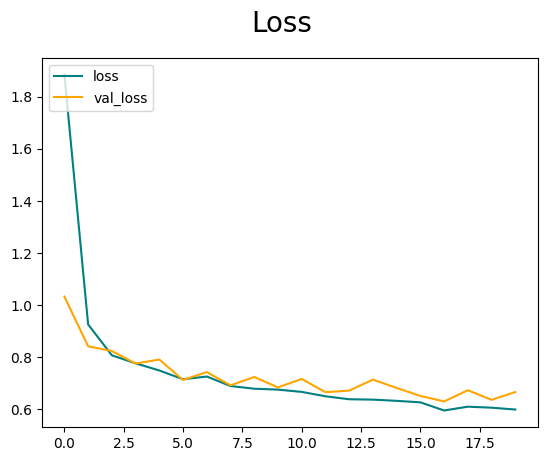

In [234]:
fig = plt.figure()

plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)

plt.legend(loc="upper left")

plt.show()

In [235]:
test = "D:\Intern\Data Science\Intern_Project\Test"  #put the testing the data path here 

In [236]:
os.listdir(test)

['conditioning excercise', 'Sports']

Loading the Testing Data

In [237]:
TESTING_DATA = tf.keras.utils.image_dataset_from_directory(test)

Found 1027 files belonging to 2 classes.


In [238]:
test_data_iterator = TESTING_DATA.as_numpy_iterator() #Changing the images as numpy arrays

In [239]:
testing_batch = test_data_iterator.next() #doing it with all the batches 

In [240]:
testing_batch[0].shape  #(size of batch, hight in pixels, width in pixels, no of colour channels)

(32, 256, 256, 3)

In [241]:
testing_batch[1]  # randomized labels 

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1])

Scaling the Testing Data

In [242]:
TESTING_DATA = TESTING_DATA.map(lambda x,y:(x/255,y))   #dividing the hight and width by 255, such that it lies [0,1]

In [243]:
testing_scaled_iterator = TESTING_DATA.as_numpy_iterator()  #Changing the scaled images as numpy arrays

In [244]:
testing_batch = testing_scaled_iterator.next()  #doing it with all the batches 

In [245]:
len(TESTING_DATA)  # We have 33 batches, each of size 32

33

In [246]:
test = TESTING_DATA

In [247]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy #importing different metrics to measure accuracy of our model

In [248]:
pre = Precision()

re = Recall()

acc = BinaryAccuracy()

In [249]:
for batch in test.as_numpy_iterator():

    X, y = batch

    yhat = model.predict(X)  #for a given input our model is predicting the output, then it is compared to the actual label and the accuracy is calculated

    pre.update_state(y, yhat)

    re.update_state(y, yhat)

    acc.update_state(y, yhat)

1/1 [==============================] - 0s 317ms/step


In [250]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.7555555701255798, Recall: 0.4035608172416687, Accuracy: 0.7614411115646362
